# exploration 09 computer vision with deepML  
###### 온라인 코어 2기 박수경  


이번 과제에서는 딥러닝 모델을 통한 image classification 과 object detection을 주어진 예제 코드를 기반으로 하여 수행해 보았다.

## 1. image classification

이미지 분류 과제에서는 대표적인 분류모델 VGG16에 대해 배우고,간단하게 그 구조를 재현해 보았다. 나아가 작성한 모델의 정확도를 53%이상으로 올리는 것을 목표로 해 본다.

VGG16은 13개의 Convolution Layer와 3개의 Fully-connected Layer로 구성되어 있다. 3\*3 필터를 2번 통과하는 것은 5\*5 필터를 1개 통과하는 것과 같은 효과라는 점에서 착안하여 3\*3 크기의 필터만을 여러 개 사용하여 속도와 효율을 높이는 전략을 사용하고 있다.  

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

이번 과제에서 분류에 사용할 데이터는 캐글의 개와 고양이 데이터로, 테스트 데이터의 1은 개, 0은 고양이를 한다.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장하고 데이터의 개수를 출력해 본다.

In [3]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


예제 코드에서 기본적으로 제시한 파라미터는 다음과 같다. 이 파라미터는 이후 성능을 높이기 위해 수정할 수 있는 부분이다. 

In [6]:
# parameter Initialization
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

이미지 확인을 위한 데이터 시각화 함수를 정의한다.

In [7]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

이미지 데이터는 총 2000장이다. 이는 크기가 작은 데이터셋이라고 볼 수 있다. 따라서 Data Augmentation(데이터 증강)을 통해 데이터의 수를 늘릴 수 있다. 회전, 살짝 밈, 확대 등의 변화를 이미지 파일에 range 범위 내 임의로 주어 학습에 이용될 이미지를 생성한다.  
결국 학습을 하게 되는 데이터이기 때문에 range 범위 조정도 영향을 미칠 것이라는 생각을 했다. 너무 많은 변형이 이루어진 이미지 데이터를 분류 학습에 이용하면 결국 정확도가 떨어질 수 있지 않을까 한다. 그렇다고 너무 적은 변형만을 거듭하면 데이터 증강의 의미가 떨어진다.

In [8]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

In [9]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary') # 개와 고양이 이진분류라서 binary

Found 2000 images belonging to 2 classes.


.flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결한다. 개와 고양이를 분류 task이므로 class_mode는 'binary'이다. Classification task에 따라 class_mode를 변경할 수 있다.

In [10]:
train_data_gen[0][0].shape

(16, 256, 256, 3)

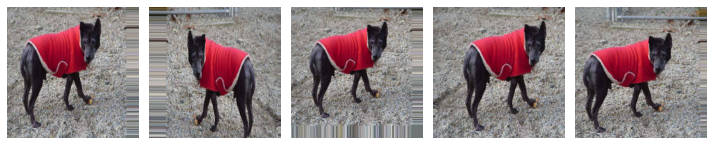

In [11]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

데이터 증강이 어떻게 이루어졌는지 확인했다. 이처럼 학습 데이터를 비슷한 맥락으로 풍부하게 만들어 학습에 사용하는 것이 재미있다고 생각했다.

In [12]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [13]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


Validation 데이터에도 train 데이터와 같이 배치사이즈와 디렉토리를 설정해 준다. 하지만 validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 변형하는 등의 조작은 하지 않고, 이미지의 스케일만 변경한다.

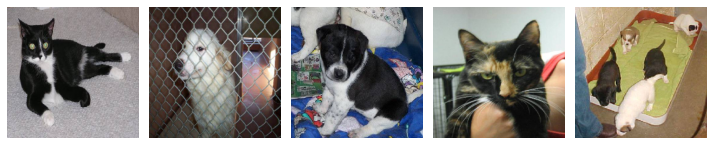

In [14]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [15]:
_[:5] # 정답 데이터

array([0., 1., 1., 0., 1.], dtype=float32)

### 1-1. VGG16 모델 구현하기

기본적으로 제시된 코드를 기반으로 vgg16 모델을 구현해 본다. 모델을 작성하는 데 있어 파라미터 설정이 핵심적인 내용이다. 조절해 볼 수 있는 다양한 방법은 다음과 같다.  

- 스킵 커넥션 추가  
- 배치 normalization  
- 옵티마이저, learning rate 조정  
- callback 함수 활용

In [16]:
# 모델 구현
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(1024, activation='relu')(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928 

In [17]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]

모델 학습을 진행한다.  
data generator는 입력 데이터와 타겟(라벨)의 batch를 끝없이 반환합니다. batch가 끝없이 생성되기 때문에, 한 번의 epoch에 generator로부터 얼마나 많은 샘플을 뽑을지 모델에 입력해야 한다.
예를 들어 batch_size=20이고 steps_per_epoch=100 라는 것은 (데이터, 라벨)의 쌍 20개가 생성되고, 크기가 20인 batch 데이터를 100번 학습하면 1 epoch이 완료된다는 의미이다. 이 지정된 크기 20의 batch 데이터는 매번 랜덤으로 생성된다.

일반적으로 (전체 데이터 길이/batch_size)를 steps_per_epoch으로 설정한다.

In [18]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 38s 258ms/step - loss: 45.2535 - binary_accuracy: 0.4960 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 2/5
125/125 [==============================] - 32s 252ms/step - loss: 0.6937 - binary_accuracy: 0.4980 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 3/5
125/125 [==============================] - 31s 249ms/step - loss: 0.6951 - binary_accuracy: 0.4820 - val_loss: 0.8841 - val_binary_accuracy: 0.5020
Epoch 4/5
125/125 [==============================] - 31s 246ms/step - loss: 0.7138 - binary_accuracy: 0.5000 - val_loss: 0.7003 - val_binary_accuracy: 0.5000
Epoch 5/5
125/125 [==============================] - 31s 248ms/step - loss: 0.7191 - binary_accuracy: 0.4875 - val_loss: 0.6970 - val_binary_accuracy: 0.5010


학습 진행 이후에는 정확도를 시각화해서 살펴본다.

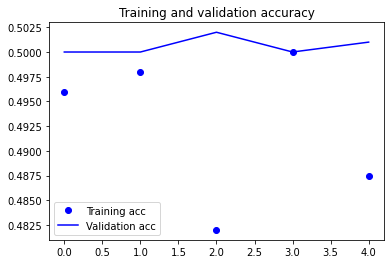

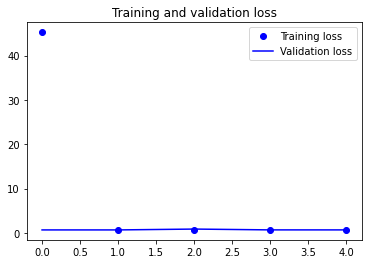

In [19]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

위 모델로는 정확도가 50%정도밖에 나오지 않는다.

### 1-2. 다양한 방법을 사용하여 모델의 성능 올리기

- hyperparameter 변경
- 모델 구조 수정
- optimizer 변경
- skip connection
- pre-trained model 

In [20]:
# hyperparameter 설정
batch_size = 32 # 배치 사이즈를 증가시켜 보았다.
epochs = 100 #학습 횟수를 늘렸다.
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [21]:
# 데이터 generator 생성
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.4, #회전 범위를 조금더 늘려보았다.
                                     width_shift_range=0.2,
                                     height_shift_range=0.15,
                                     zoom_range=0.4, #조금 더 확대범위를 늘려보았다.
                                     horizontal_flip=True, 
                                     vertical_flip=False)  #상하는 뒤집을 필요가 없는 것 같다.  

데이터 제네레이터를 바꾸어 보았다. 이미지를 생성해 내는 범위를 조금 더 늘려서 더욱 풍부한 학습자료로 삼을 수 있게 하면 좋겠다는 생각이 들어서였다.

In [22]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')  #개, 고양이 이진분류

Found 2000 images belonging to 2 classes.


vgg16 모델을 구현해 보았다. vgg16의 구조는

In [23]:
# 모델
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x2=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x2=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x2)
x2=tf.keras.layers.BatchNormalization()(x2)
x2=tf.keras.layers.MaxPool2D((2, 2))(x2)


x2=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x2)
x2=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x2)
x2=tf.keras.layers.BatchNormalization()(x2)
x2=tf.keras.layers.MaxPool2D((2, 2))(x2)



x2=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x2)
x2=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x2)
x2=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x2)
x2=tf.keras.layers.BatchNormalization()(x2)
x2=tf.keras.layers.MaxPool2D((2, 2))(x2)


x2=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x2)
x2=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x2)
x2=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x2)
x2=tf.keras.layers.BatchNormalization()(x2)
x2=tf.keras.layers.MaxPool2D((2, 2))(x2)


x2=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x2)
x2=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x2)
x2=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x2)
x2=tf.keras.layers.BatchNormalization()(x2)
x2=tf.keras.layers.MaxPool2D((2, 2))(x2)

x2=tf.keras.layers.Flatten()(x2)
x2=tf.keras.layers.Dense(1024, activation='relu')(x2)
x2=tf.keras.layers.Dense(512, activation='relu')(x2)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x2)

model2 = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 128)     1475

In [24]:
# loss function, optimizer, metric 설정 및 모델 컴파일
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.0001)
metric=tf.keras.metrics.binary_accuracy
model2.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

In [25]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [26]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [27]:
# 모델 학습
history2 = model2.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/100
62/62 [==============================] - 66s 841ms/step - loss: 0.9880 - binary_accuracy: 0.5685 - val_loss: 0.8024 - val_binary_accuracy: 0.5000
Epoch 2/100
62/62 [==============================] - 43s 684ms/step - loss: 0.6856 - binary_accuracy: 0.5925 - val_loss: 0.7760 - val_binary_accuracy: 0.5000
Epoch 3/100
62/62 [==============================] - 43s 684ms/step - loss: 0.6314 - binary_accuracy: 0.6685 - val_loss: 1.0848 - val_binary_accuracy: 0.5000
Epoch 4/100
62/62 [==============================] - 43s 684ms/step - loss: 0.6300 - binary_accuracy: 0.6555 - val_loss: 0.8356 - val_binary_accuracy: 0.5000
Epoch 5/100
62/62 [==============================] - 43s 683ms/step - loss: 0.5924 - binary_accuracy: 0.6955 - val_loss: 0.8759 - val_binary_accuracy: 0.5000
Epoch 6/100
62/62 [==============================] - 43s 685ms/step - loss: 0.5889 - binary_accuracy: 0.6890 - val_loss: 1.4045 - val_binary_accuracy: 0.5000
Epoch 7/100
62/62 [==============================] -

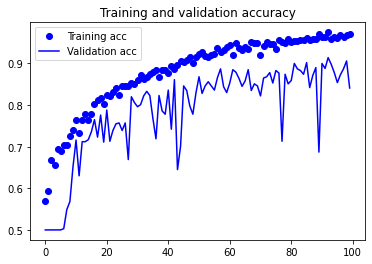

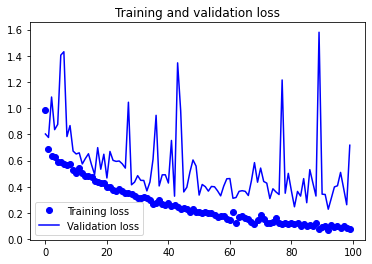

In [28]:
acc = history2.history['binary_accuracy']
val_acc = history2.history['val_binary_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 1-3. Discussion

vgg16 모델의 기본구조를 직접 구현해 보며 이미지 분류 모델이 분류를 수행하는 과정을 하나하나 생각해 볼 수 있었다. 조금 더 높을 성능을 위해 다양하게 파라미터를 바꾸어 가며 시도해 볼 수 있는 것을 경험하게 되었다. 하지만 구글 코랩 가상환경에서 gpu를 사용해 한 번 학습하고 결과를 보는 데 시간이 오래 걸리는 점이 어렵게 다가왔다.  

경사하강법으로 global minimum을 찾아가는 과정에는 step-size가 가장 큰 영향을 미치는 것 같다. 그에는 batch size 와 learning rate 가 가장 중요하다. 이를 실험적으로 여러번 시도해 볼 수 있어서 좋았다.  

Epoch의 조정도 큰 영향을 미쳤다.  
오버피팅이 일어나기 전까지는 학습횟수가 증가함에 따라 성능도 증가하기 때문이다.

또한 우리가 학습의 기반으로 삼는 데이터는 2000장 정도로, 작은 크기라고 볼 수 있는데 따라서 이미지 증강을 시키는 함수를 조금 더 풍부하게 해 보았다. 정확도에 영향을 미쳤다. 학습하는 데이터에 따라서도 성능이 변화함을 경험해 볼 수 있었다.

## 2. Object Detection

이번 과제에서는 텐서플로우 공식 홈페이지의 튜토리얼에서 제시된 코드를 활용해 object detection의 과정을 배워보았다. object detection은 image 의 localization과 classification을 함께 수행하여야 하는 문제로, 단순하게 분류하는 것보다 조금 더 복잡한 과정이라고 볼 수 있다.

In [29]:
!pip3 install tensorflow-estimator==2.6.0

In [30]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈 
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile 
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

이미지를 시각화하는 함수를 만들어 둔다.

In [31]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

원하는 이미지를 다운로드하고 정해진 가로, 세로 길이에 맞게 이미지를 resizing하는 함수를 만든다. 

In [32]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False): 
  
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

Bounding Box를 만드는 함수를 만든다.

In [33]:
def draw_bounding_box_on_image(image, 
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

이미지 위에 class 이름과 score를 나타내는 함수를 만든다.

In [34]:
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1): 
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

원하는 이미지를 불러와 resizing한다.

Image downloaded to /tmp/tmpeh0do5_p.jpg.


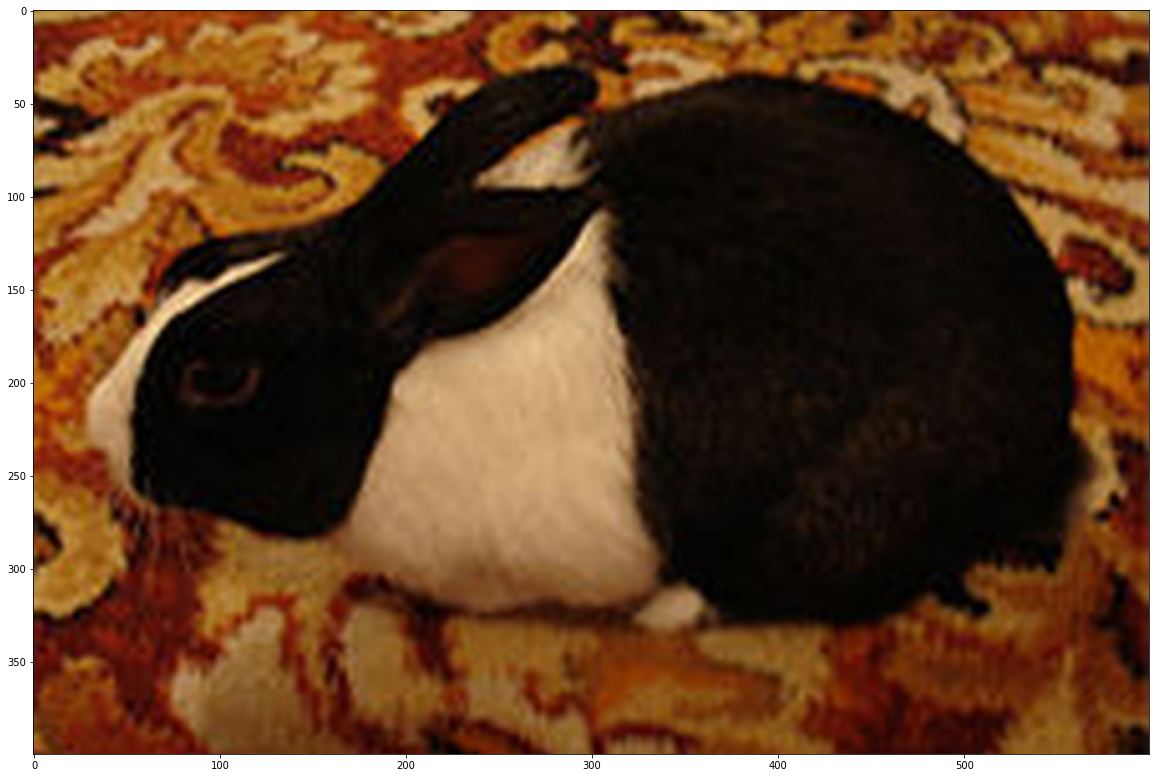

In [35]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1c/Random_006.jpg/220px-Random_006.jpg"
downloaded_image_path = download_and_resize_image(image_url, 600, 400, True)  # new_width와 new_height를 변경

tfhub에서 사전 학습된(Pre-trained) InceptionResnet 모델을 사용한 Faster RCNN 모델을 불러온다.

In [36]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [37]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

Detector를 실행하는 함수를 만든다.

In [38]:
def run_detector(detector, path):
  img = load_img(path) 

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

detector를 실행시킨다.

Found 100 objects.
Inference time:  37.65801692008972


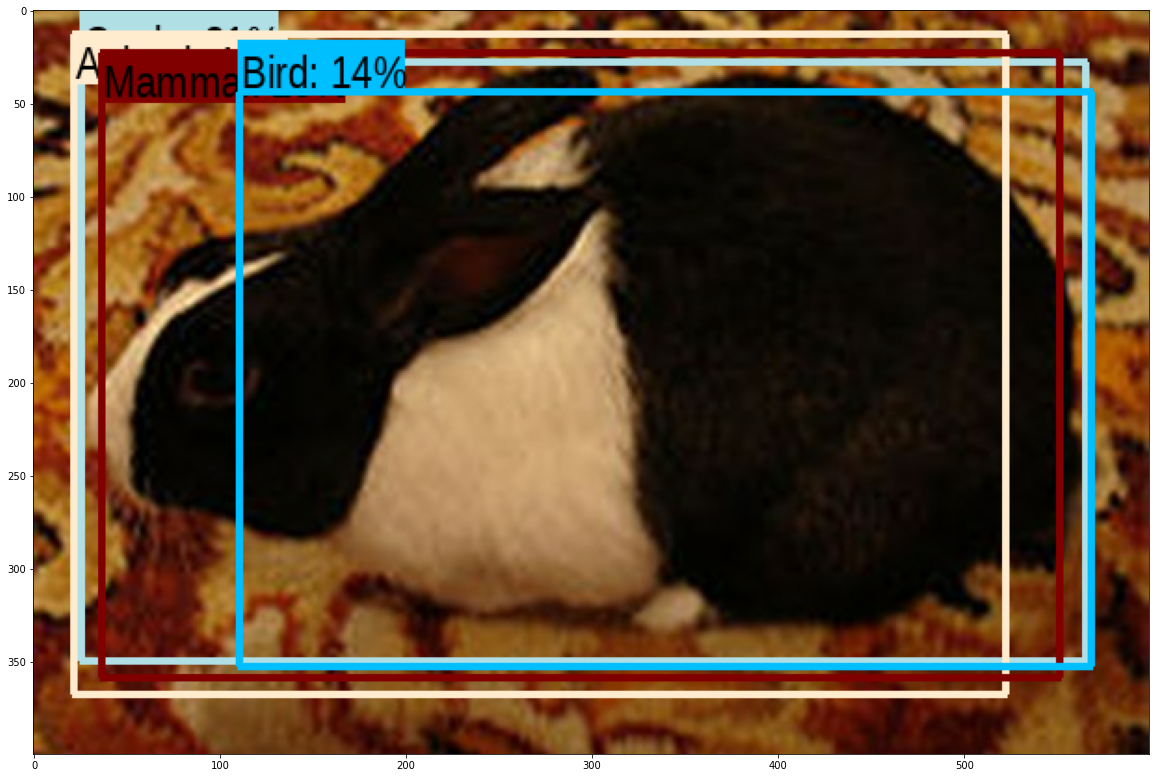

In [39]:
run_detector(detector, downloaded_image_path)

### 2-1. 다른 이미지 테스트해보기
원하는 이미지를 불러와 결과를 확인한다.

Image downloaded to /tmp/tmpo7rkxxgh.jpg.


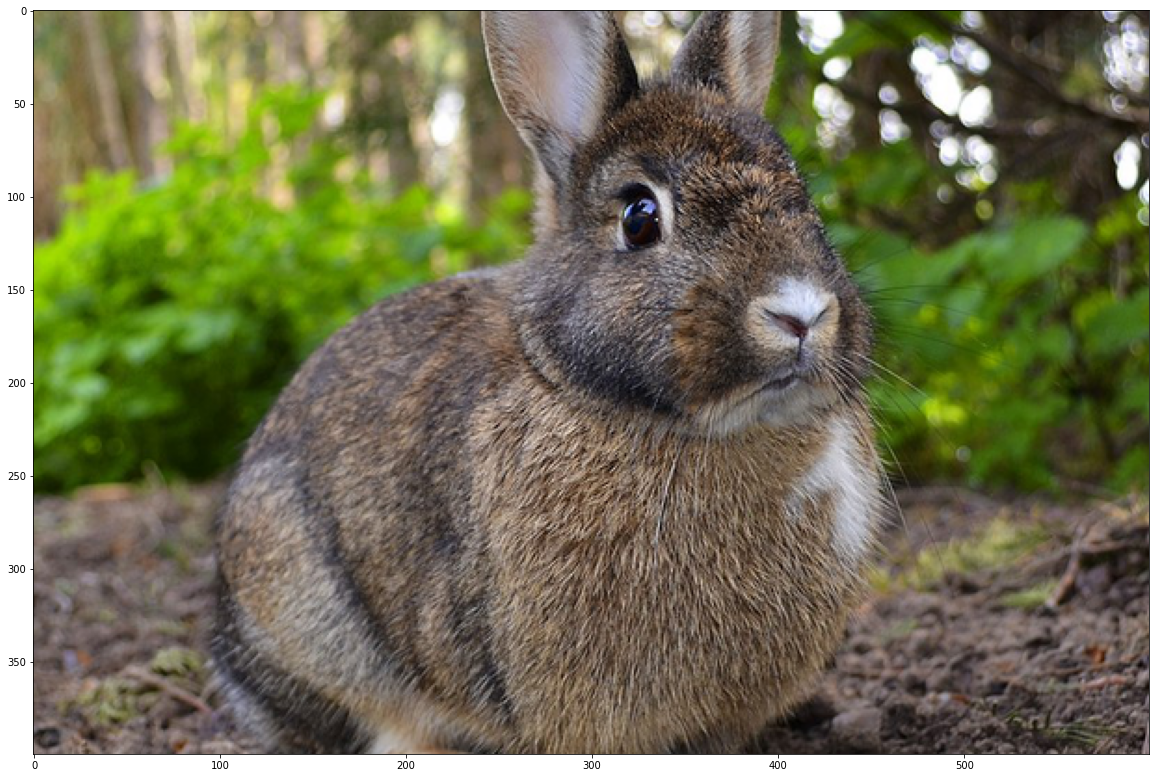

In [46]:
# 이미지 불러오기
image_url2 = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Oryctolagus_cuniculus_Rcdo.jpg/800px-Oryctolagus_cuniculus_Rcdo.jpg"
downloaded_image_path2 = download_and_resize_image(image_url2, 600, 400, True)  # new_width와 new_height를 변경

Found 100 objects.
Inference time:  1.3635120391845703


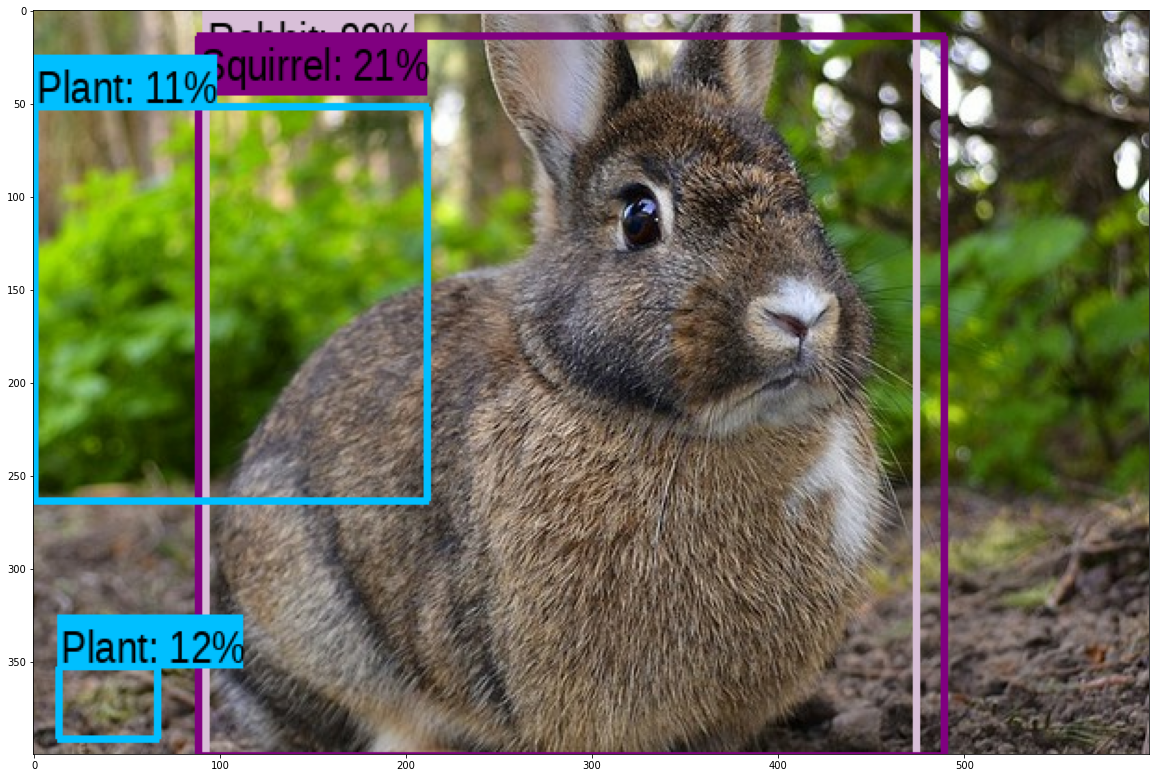

In [47]:
# # 테스트
# module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  

# detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

run_detector(detector, downloaded_image_path2)

### 2-2. 다양한 pre-trained model 테스트해보기
Faster RCNN 외에도 Object Detection을 할 수 있는 다양한 사전 학습 모델이 있다. 텐서플로우 허브에서 mobilenet_v2을 불러와 테스트해 보았다.

In [50]:
module_handle2 = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" 
detector2 = hub.load(module_handle2).signatures['default'] # detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Found 100 objects.
Inference time:  5.870426416397095


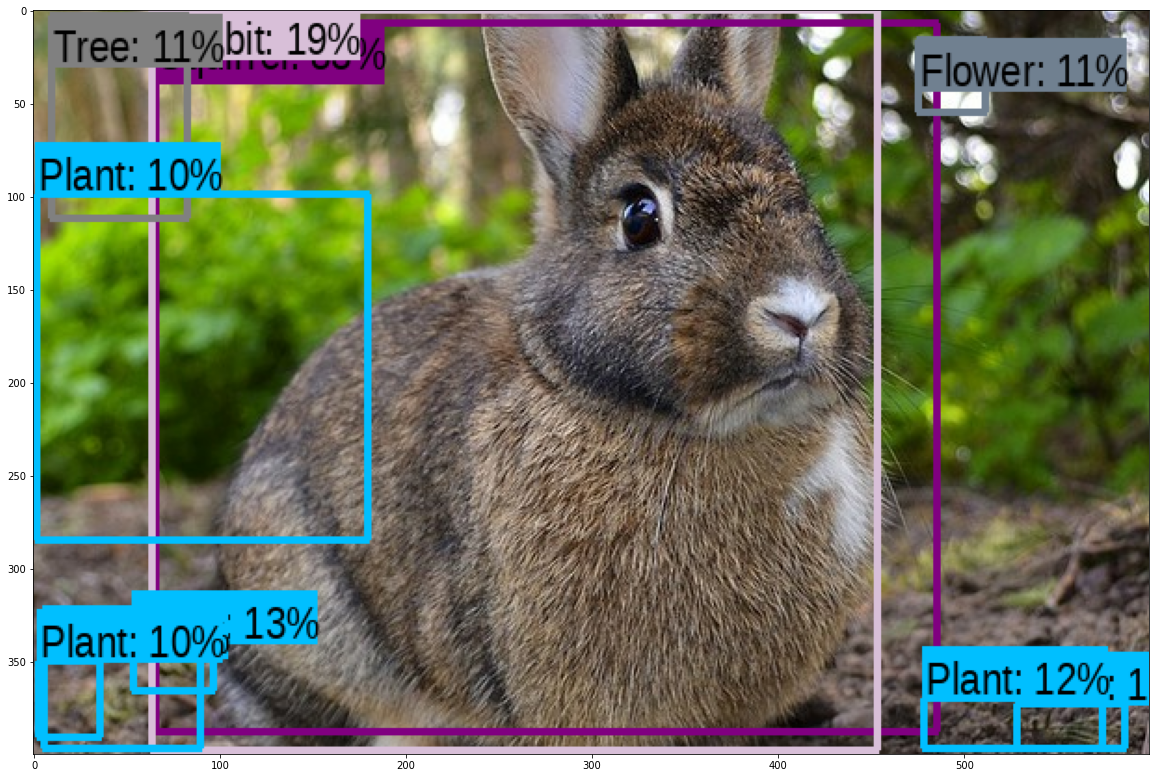

In [52]:
run_detector(detector2, downloaded_image_path2)

In [53]:
# 결과 비교
print("1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였다.") 
print("2번째 모델인 mobilenet_v2/1은 Faster RCNN보다 느리고 정확도도 낮았다. ")

1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였다.
2번째 모델인 mobilenet_v2/1은 Faster RCNN보다 느리고 정확도도 낮았다. 


### 2-3.Discussion

기본적으로 제시된 코드를 이해하는 것에 중점을 두었다. 실제로 이미지 속 objects를 detecting 하는 Faster RCNN은 수많은 ROI 후보군을 만들고 그 중 괜찮은 ROI를 학습해,classification을 수행하는 2-stage-detector이다.
![](https://d3s0tskafalll9.cloudfront.net/media/images/NoDeu10_FasterRCNN_2.max-800x600.png)  

바운딩박스를 그려주고, 클래스와 스코어를 표시해 주는 함수를 직접 작성해 보면서 Object detection이 표시되는 과정을 알아볼 수 있어서 좋았다.  
tfhub에서 다양한 모델을 불러와서 시도해 보려고 할 때, 불러오는 데 오류가 생기는 모델이 있었는데 각 모델의 설명 페이지에서 input과 output 란을 잘 보고 맞추어서 사용해야 한다는 것을 알았다. 더 다양하게 시도하지 못한 것이 아쉽다. usage 예를 보고 과제에 맞게 적용하는 것을 이후에 시도해 보려고 한다.

